## Header 
Author : Amina Matt and Yichen Wang  
Date created : 14.10.2021  
Date last modified : 21.11.2021  
Python version : 3.8  
Description : Text processing of the CARICOM Compilation Archive (CCA) https://louverture.ch/cca/ 



# To Do List
- [X] check number items
- [X] to JSON 
- [X] JSON fix None answer
- [ ] Add colonial location
- [ ] JSON cleaning of parenthesis in names?
- [ ] save NER 

# Initialization

In [2]:
# -*- coding: utf-8 -*-

import nltk #Natural Language Toolkit is a natural language programming library
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import pandas as pd
from nltk import pos_tag
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk.chunk import conlltags2tree
from nltk.tree import Tree
import random
from pandas.io.json import json_normalize


#PATHS
DATA_FOLDER = './data/'
caricom_sample = DATA_FOLDER +'Caricom_Archive_Sample_Schema1.txt'
caricom = DATA_FOLDER +'Caricom_Archive.txt'

# Text separation into items 
In the primary text source, each item is separated by a return and the '=>' starting string. Each item references a different actor of colonial entreprise. Separating each of them into items helps us to differentiate the extraction depending on the scheme they follow.

In [1186]:
#Input: path for the .txt file 
#Output: list of string, where each element is an item, i.e. a separate entry in the document of origin
#Requirements: -
#Description: separate the items based on the '=>' string that characterize a new entry
def divide_items(textFilePath):
    f = open(textFilePath,"r")
    item = []
    flagTOC = False
    for line in f: 
        
     
        
        if (line == '1 CARICOM MEMBER STATES\n') :
            flagTOC = True #the TOC has been fully read
            print('the TOC has been read')
            
        if flagTOC : #check if line is a TOC entry
            if (line[0].isdigit()) and  (line[1] == '.') and (line[2].isdigit()) : #we have a subTOC entry, level n.n
                #For United States
                if (line[0] == '3') and (line[3] == '.'):
                    colonialIndex = line[0:5] 
                else :
                    colonialIndex = line[0:3]
                    colonialIndex = colonialIndex.replace('\n','')
                #print('the colonial index is ' + str(colonialIndex))
              
        if (line != '\n'):
            if (line[0] == '=') and (line[1] == '>'):
                item_text = ''
                while (line != '\n'):
                    item_text = item_text + line
                    line = f.readline()
                #Once the item is read we add its colonial index that corresponds to a TOC entry
                #We add the index at the end to retrieve it easily
                item_text = item_text.replace('\n','') 
                #print(item_text)
                item_text = item_text + (' '+colonialIndex)
                #print('The text item now has the colonial index'+item_text)
                item.append(item_text)
    f.close()
    return item 

In [1294]:
text_items = divide_items(caricom)
items_total = len(text_items)
print(f'There are {len(text_items)} items in total.')

the TOC has been read
There are 464 items in total.


In [1293]:
print(f'This is one text item:\n{text_items[random.randrange(len(text_items))]}.\n')

This is one text item:
=> Jacob Burckhardt (1818–1897) from Basel was a world-famous Swiss historian of art and culture and an influential figure in historiography. In his university lectures Reflections on History (1868-1871), later published as a book, he took anti-semitic, anti-democratic and racist positions. He differentiated between higher races and «lesser races», «negro peoples», «savages» and «semi-savages». On the latter, he wrote, «For such peoples are from the outset a prey to everlasting fear; their religions do not even give us a standard for the first signs of the birth of the spirit, because among them the spirit is destined never to come to spontaneous birth.» Later he raised the questions (without answering them), «How far are inferior peoples held in their uncivilized condition by their religions of fear? Or do those religions subsist because the race is uncivilizable?» Of Abessynians, he thought very little and claimed, «The Christianity of Abyssinia and other total

## Table of Contents retrieving

In [1184]:
def tocList_func(textFilePath):
    f = open(textFilePath,"r")
    tocList = []
    for line in f: 
        if (line == '1 CARICOM MEMBER STATES\n') :
            break
        else : 
            if (line[0].isdigit()) and  (line[1] == '.') and (line[2].isdigit())  : #we have a subTOC entry, level n.n
                toc = (line[0:3],line[4:-1])
            #For United States
                if (line[0] == '3') and (line[3] == '.'):
                    toc = (line[0:5],line[6:-1]) #print(toc)
                tocList.append(toc)
    #manual cleaning 
    tocList[5]=('1.6','Guyana')
    tocList[9]=('1.7','Haiti')
    tocList[5]=('1.6','Guyana')
    tocList[9]=('1.7','Haiti')
    tocList[19]=('2.2','Netherlands Antilles')
    tocList[20]=('2.3','French West Indies')
    tocList[21]=('2.4','Danish West Indies')
    tocList[24]=('3.1','North America')
    tocList[38]=('3.2','Brazil')
    #as these concern contribution over all the region there are in switzerland
    tocList[41]=('4.1','Switzerland')
    tocList[42]=('4.2','Switzerland')
    tocList[43]=('4.3','Switzerland')
    f.close()
    return tocList
tocList = tocList_func(caricom)   

In [1185]:
tocList

[('1.1', 'Antigua and Barbuda'),
 ('1.2', 'Bahamas'),
 ('1.3', 'Barbados'),
 ('1.4', 'Dominica'),
 ('1.5', 'Grenada'),
 ('1.6', 'Guyana'),
 ('1.6', '1 Berbice'),
 ('1.6', '2 Demerara (Demerrara, Demerary)'),
 ('1.6', '3 Essequibo'),
 ('1.7', 'Haiti'),
 ('1.7', '1 Economic'),
 ('1.7', '2 Military'),
 ('1.7', '3 Ideological'),
 ('1.8', 'Jamaica'),
 ('1.9', 'Montserrat'),
 ('1.1', ' St. Vincent & The Grenadines'),
 ('1.1', ' Suriname'),
 ('1.1', ' Trinidad and Tobago'),
 ('2.1', 'Cuba'),
 ('2.2', 'Netherlands Antilles'),
 ('2.3', 'French West Indies'),
 ('2.4', 'Danish West Indies'),
 ('2.5', 'Venezuela'),
 ('2.6', 'Bermudas'),
 ('3.1', 'North America'),
 ('3.1.1', 'Alabama'),
 ('3.1.2', 'Arkansas'),
 ('3.1.3', 'California'),
 ('3.1.4', 'Carolinas'),
 ('3.1.5', 'Florida'),
 ('3.1.6', 'Georgia'),
 ('3.1.7', 'Kentucky'),
 ('3.1.8', 'Louisiana'),
 ('3.1.9', 'Mississippi'),
 ('3.1.1', ' New York'),
 ('3.1.1', ' Tennessee'),
 ('3.1.1', ' Texas'),
 ('3.1.1', ' Virginia'),
 ('3.2', 'Brazil'),
 (

In [1170]:
def colonial_location(text,tocList) :
    tocFromText = text[len(text)-1]#the last item is the TOC entry 
    #print(tocFromText)
    tocListIndex = [x[0] for x in tocList]
    index = tocListIndex.index(tocFromText)
    colonialLoc = tocList[index][1]
#     sublocationList = ['Berbice','Demerara','Demerary','Essequibo',
#                        'Aruba','Bonaire','Curaçao','St. Eustacius',
#                        'Guiana','Guadeloupe','Martinique','St. John', 'St. Croix','St. Thomas']
        
#     for location in sublocationList:
#         if location in text : 
#             colonialLoc = location
    return colonialLoc 

## Named Entities Recognition with NER Stanford 
The first objective is to extract information of interest from the text. In this case we are interested in person's names, locations and activities. The first step towards this goal is to use Named Entities Recognition to recognize which words contain the information we are looking for.

In [7]:
#Stanford NER 
NER_FOLDER = './NER-Standford/stanford-ner-2020-11-17'
CLASSIFIER_PATH = NER_FOLDER+'/classifiers/'
JAR_PATH = NER_FOLDER+'/stanford-ner.jar'

#classifiers
classifier_3 = 'english.all.3class.distsim.crf.ser.gz'#3 class model for recognizing locations, persons, and organizations
classifier_4 = 'english.conll.4class.distsim.crf.ser.gz'#4 class model for recognizing locations, persons, organizations, and miscellaneous entities
classifier_7 = 'english.muc.7class.distsim.crf.ser.gz' #7 class model for recognizing locations, persons, organizations, times, money, percents, and dates

st = StanfordNERTagger(CLASSIFIER_PATH+classifier_7, JAR_PATH, encoding='utf-8')



#Extracting named-entities
text = open(caricom_sample, 'r').read()
tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

[('=', 'O'), ('>', 'O'), ('François', 'PERSON'), ('Aimé', 'PERSON'), ('Louis', 'PERSON'), ('Dumoulin', 'PERSON'), ('(', 'O'), ('1753-1834', 'O'), (')', 'O'), ('from', 'O'), ('Vevey', 'LOCATION'), ('(', 'O'), ('Canton', 'LOCATION'), ('of', 'O'), ('BerneVaud', 'O'), (')', 'O'), ('left', 'O'), ('Switzerland', 'LOCATION'), ('at', 'O'), ('the', 'O'), ('age', 'O'), ('of', 'O'), ('20', 'O'), ('for', 'O'), ('the', 'O'), ('Caribbean', 'LOCATION'), ('and', 'O'), ('lived', 'O'), ('on', 'O'), ('Grenada', 'LOCATION'), ('1773–1783', 'O'), ('.', 'O'), ('He', 'O'), ('worked', 'O'), ('as', 'O'), ('a', 'O'), ('painter', 'O'), (',', 'O'), ('secretary', 'O'), ('to', 'O'), ('the', 'O'), ('governor', 'O'), ('of', 'O'), ('the', 'O'), ('island', 'O'), (',', 'O'), ('and', 'O'), ('merchant', 'O'), ('.', 'O'), ('In', 'O'), ('1778', 'DATE'), (',', 'O'), ('he', 'O'), ('was', 'O'), ('pressed', 'O'), ('into', 'O'), ('the', 'O'), ('English', 'O'), ('army', 'O'), ('of', 'O'), ('Governor', 'O'), ('MacCartney', 'O'), ('

At this point the whole text is tagged. However the entities aren't grouped together. For example, a person full name is separate into two tuples.

## BIO tagging for readable Named Entities (i.e. regrouped NE)

[BIO](https://en.wikipedia.org/wiki/Inside–outside–beginning_(tagging)) tags are a way to regroup tokens, to make the output more readable. 
A person name with first and last name should be regroup by assigning  
 -B to the beginning of named entities  
 -I assigned to inside  
 -O assigned to other  
This is done by checking the tokens just before and after the one of interest.

In [8]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Tag tokens with standard NLP BIO tags
def bio_tagger(ne_tagged):
		bio_tagged = [] #empty list
		prev_tag = "O" #starting with a O tag
		for token, tag in ne_tagged:
			if tag == "O": #O
				bio_tagged.append((token, tag))
				prev_tag = tag
				continue
			if tag != "O" and prev_tag == "O": # Begin NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag == tag: # Inside NE
				bio_tagged.append((token, "I-"+tag))
				prev_tag = tag
			elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
				bio_tagged.append((token, "B-"+tag))
				prev_tag = tag
		return bio_tagged

In [9]:
bio_text = bio_tagger(classified_text)
bio_text

[('=', 'O'),
 ('>', 'O'),
 ('François', 'B-PERSON'),
 ('Aimé', 'I-PERSON'),
 ('Louis', 'I-PERSON'),
 ('Dumoulin', 'I-PERSON'),
 ('(', 'O'),
 ('1753-1834', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Vevey', 'B-LOCATION'),
 ('(', 'O'),
 ('Canton', 'B-LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('Switzerland', 'B-LOCATION'),
 ('at', 'O'),
 ('the', 'O'),
 ('age', 'O'),
 ('of', 'O'),
 ('20', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('Caribbean', 'B-LOCATION'),
 ('and', 'O'),
 ('lived', 'O'),
 ('on', 'O'),
 ('Grenada', 'B-LOCATION'),
 ('1773–1783', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('worked', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('painter', 'O'),
 (',', 'O'),
 ('secretary', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('governor', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('merchant', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('1778', 'B-DATE'),
 (',', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('pressed', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('English',

Using the BIO tags we can recreate a tokens list with regrouped/readable named entities. 

In [10]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Create tree       
def stanford_tree(bio_tagged):
	tokens_raw, ne_tags = zip(*bio_tagged)
	tokens = [word for word in tokens_raw if word]
	pos_tags = [pos for token, pos in pos_tag(tokens)]

	conlltags = [(token, pos, ne) for token, pos, ne in zip(tokens, pos_tags, ne_tags)]
	ne_tree = conlltags2tree(conlltags) #from BIO to tree format
	return ne_tree

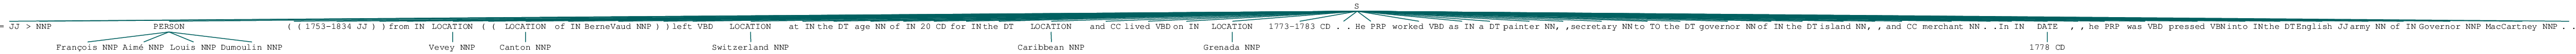

In [11]:
tree_text = stanford_tree(bio_text)
tree_text

In [12]:
# Function imported from 
# https://pythonprogramming.net/using-bio-tags-create-named-entity-lists/?completed=/testing-stanford-ner-taggers-for-speed/

# Parse named entities from tree
def structure_ne(ne_tree):
	ne = []
	for subtree in ne_tree:
		if type(subtree) == Tree: # If subtree is a noun chunk, i.e. NE != "O"
			ne_label = subtree.label()
			ne_string = " ".join([token for token, pos in subtree.leaves()])
			ne.append((ne_string, ne_label))
		else:
			ne_label = 'O'
			ne_string = subtree[0]
			ne.append((ne_string, ne_label))           
	return ne

In [13]:
clean_ne = structure_ne(tree_text)
clean_ne

[('=', 'O'),
 ('>', 'O'),
 ('François Aimé Louis Dumoulin', 'PERSON'),
 ('(', 'O'),
 ('1753-1834', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('Vevey', 'LOCATION'),
 ('(', 'O'),
 ('Canton', 'LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('Switzerland', 'LOCATION'),
 ('at', 'O'),
 ('the', 'O'),
 ('age', 'O'),
 ('of', 'O'),
 ('20', 'O'),
 ('for', 'O'),
 ('the', 'O'),
 ('Caribbean', 'LOCATION'),
 ('and', 'O'),
 ('lived', 'O'),
 ('on', 'O'),
 ('Grenada', 'LOCATION'),
 ('1773–1783', 'O'),
 ('.', 'O'),
 ('He', 'O'),
 ('worked', 'O'),
 ('as', 'O'),
 ('a', 'O'),
 ('painter', 'O'),
 (',', 'O'),
 ('secretary', 'O'),
 ('to', 'O'),
 ('the', 'O'),
 ('governor', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('island', 'O'),
 (',', 'O'),
 ('and', 'O'),
 ('merchant', 'O'),
 ('.', 'O'),
 ('In', 'O'),
 ('1778', 'DATE'),
 (',', 'O'),
 ('he', 'O'),
 ('was', 'O'),
 ('pressed', 'O'),
 ('into', 'O'),
 ('the', 'O'),
 ('English', 'O'),
 ('army', 'O'),
 ('of', 'O'),
 ('Governor', 'O'),
 ('MacCartn

In [14]:
def ner_text(text):
    tokenized_text = word_tokenize(text)
    classified_text = st.tag(tokenized_text)
    bio_text = bio_tagger(classified_text)
    tree_text = stanford_tree(bio_text)
    ner_item = structure_ne(tree_text)
    return ner_item

# All functions

In [1633]:
def text_and_tags(item):
    #Default
    schema1 = False
    s1item_JSON = None
    #Separate text and tags
    text = [x[0] for x in item]
    tags = [x[1] for x in item]
    return text,tags



def person_index(text,tags):
    ##--Start and end of piece of interest, i.e. ...'PERSON'.....'LOCATION'--##
    try:
        person_Index = tags.index('PERSON')
        #print("Item does contain a PERSON value"+str(text[person_Index]))
    except ValueError:
        person_Index = -1 #default
        #print("Item does not contain a PERSON value")
    return person_Index

def origin_location_index(text,tags):
    #The origin location can be found with LOCATION tags. But it should, according to schema 2 also be just after the 'from'.. confidence will tell us if it is both sources or not
    #Origin Method 1
    try:
        #Case 1: 1 word origin location
        origin_Index_method1 = text.index('from')
        origin_1 = text[origin_Index_method1+1]
        #Case 2: 2 words origin location, e.g. Le Locle 
        #print('First letter' + text[origin_Index_method1+2][0])
        if (text[origin_Index_method1+2][0]).isupper() : 
            origin_1 = origin_1 +' '+ text[origin_Index_method1+2]
        #Case 3: the City of Location, e.g. the City of Geneva
        if ((text[origin_Index_method1+2]) == 'City') or  ((text[origin_Index_method1+2]) == 'Canton'): 
            origin_1 = text[origin_Index_method1+4]
        #print('The origin index using from gives origin as :' + origin_1)
    except ValueError:
        #print("Item does not contain any FROM string")
        #print(text)    
        origin_1 = -1 #default
        origin_Index_method1 = -1
    
    
    #Origin Method2
    try: 
        origin_Index_method2 = tags.index('LOCATION')
    except ValueError:
        #print("Item does not contain a LOCATION value")
        origin_Index_method2 = -1 #default
        
    #Check if both methods give the same answers
    o_confidence = (origin_Index_method1 == origin_Index_method2)
    return origin_Index_method1,origin_1,o_confidence
  
def person_location(person_Index,origin_Index_method1) :
    #If there are PERSON and LOCATION values, with PERSON first we continue the schema1 test
    flag = (person_Index < origin_Index_method1) and (person_Index > 0) and (origin_Index_method1 > 0)
    return flag    
    

def date(text,tags,person_Index,origin_Index_method1):
    #SCHEMA 2
    #In YEAR' test 
    inYear = (text[2] == 'In') and (len(text[3]) == 4) and (text[3].isdigit())
    #print('This item looks like an schema 2 item '+str(inYear) + str(text[2:4]))
    if inYear : 
        date = text[3]
        return date
    
    else :
    #SCHEMA 1
    #(date)
        #Define part in between PER and LOC tags
        ner_middle = item[person_Index+1:origin_Index_method1]
        text_middle = text[person_Index+1:origin_Index_method1]

        #Parenthesis test
        try:
            par1_Index = text_middle.index('(')
        except ValueError:
            par1_Index = -1 #default

        try:
            par2_Index = text_middle.index(')')
        except ValueError:
            par2_Index = -1 #default

        #If there are parenthesis
        if par1_Index < par2_Index and par2_Index >= 0 and par1_Index >= 0 :
            date_par = text_middle[par1_Index+1:par2_Index]
            date = str(date_par[0])
            return date
        else :
            return None

def colonial_location(text,tocList) :
    #TOC section number
    tocFromText = text[len(text)-1]#the last item is the TOC entry 
    #print(tocFromText)
    
    # only TOC section numbers
    tocListIndex = [x[0] for x in tocList]
    
    # find position of TOC section number in toclist section numbers
    index = tocListIndex.index(tocFromText)
    
    # use position to retrieve location name 
    colonialLoc = tocList[index][1]
#     sublocationList = ['Berbice','Demerara','Demerary','Essequibo',
#                        'Aruba','Bonaire','Curaçao','St. Eustacius',
#                        'Guiana','Guadeloupe','Martinique','St. John', 'St. Croix','St. Thomas']
        
#     for location in sublocationList:
#         if location in text : 
#             colonialLoc = location
    return colonialLoc 

def accuracy(tags):
    #activity_occurences = ...
    #acc_activity = 1/activity_occurences * 100
    try :
        acc_date = 1/tags.count('DATE') * 100
    except: 
        acc_date = 100
    try :    
        acc_person = 1/tags.count('PERSON') * 100
    except: 
        acc_person = 100
    try :
        acc_origin = 1/tags.count('LOCATION') * 100
    except: 
        acc_origin = 100
    return [acc_date,acc_person,acc_origin]

## Main function

In [1634]:
jsonList= []
i = 0
s1 = 0
person_iter = 0
origin_iter = 0
for item in text_items:
        nerItem = ner_text(item)
        text_tags = text_and_tags(nerItem)
        personIndex = person_index(text_tags[0],text_tags[1])
        origin_info = origin_location_index(text_tags[0],text_tags[1]) #origin_Index_method1,origin,o_confidence

        #Test if it will be one of the two schemas
        if person_location(personIndex,origin_info[0]) :
            person = text_tags[0][personIndex]
            origin = origin_info[1]
            
            #Retrieve date according to schema1 or schema2 if no date then None
            dateValue = date(text_tags[0],text_tags[1],personIndex,origin_info[0])
            
            #Retrieve colonial location
            colonialLoc = colonial_location(text_tags[0],tocList)
                    
            #Whole entry without location index
            item_clean = item[0:(len(item)-3)]
            #Calculate accuracy 
            [acc_date,acc_person,acc_origin] = accuracy(text_tags[1])
            #Create a JSON dictionary
            item_JSON = {
                'person' : person,
                'date': dateValue,
                'origin': origin,
                'colonial_Location': colonialLoc,
                'confidence_date':acc_date,
                'confidence_person':acc_person,
                'confidence_origin':acc_origin,
                'whole_entry': item_clean
                #'field':NA
            }
            jsonList.append(item_JSON)
        
        #if no location but person 
        if (origin_info[0]== -1) and (personIndex != -1):
            print('In the no location part')
            person = text_tags[0][personIndex]
            if ('Geneva' in text_tags[0]) :
                origin = 'Geneva'
                
            if ('Neuchâtel' in text_tags[0]) :
                origin = 'Neuchâtel'
                
            #we look for date in the 15 next wwords
            dummy_origin_index = personIndex + 15
            
            #Retrieve date according to schema1 or schema2 if no date then None
            dateValue = date(text_tags[0],text_tags[1],personIndex,dummy_origin_index)
            
            #Retrieve colonial location
            colonialLoc = colonial_location(text_tags[0],tocList)
                    
            #Whole entry without location index
            item_clean = item[0:(len(item)-3)]
            
            #Calculate accuracy 
            [acc_date,acc_person,acc_origin] = accuracy(text_tags[1])
           
            #Create a JSON dictionary
            item_JSON = {
                'person' : person,
                'date': dateValue,
                'origin': origin,
                'colonial_Location': colonialLoc,
                'confidence_date':acc_date,
                'confidence_person':acc_person,
                'confidence_origin':acc_origin,
                'whole_entry': item_clean
                #'field':NA
            }
            jsonList.append(item_JSON)  
#         else :
#             if (personIndex == -1) : 
#                 person_iter = person_iter +1
#             if (origin_info[0] == -1) : 
#                 origin_iter = origin_iter +1
            #print('This item doesnt follow one of the two scheme because it doesnt have a person or location in the right order')
        #print(item_JSON)

In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no location part
In the no locati

In [1635]:
print(f'There are {len(text_items)} text items from the division of the initial page')
print(f'There are {len(jsonList)} entries after extraction of text of interest')

There are 464 text items from the division of the initial page
There are 347 entries after extraction of text of interest


Reasons for the decrease of entries:

In [1636]:
print(f'There are {person_iter} items without person name, and {origin_iter} item without origin location')

There are 0 items without person name, and 0 item without origin location


In [1637]:
len(text_items) - (person_iter+origin_iter+len(jsonList))

117

### test zone

### test zone --end

### Accuracy level


In [1638]:
tmp = text_items[35]
nerItem = ner_text(tmp)
tags = text_and_tags(nerItem)[1]

The classification accuracy is calculated based on the amount of complexity of the item. A very simple item that will contains only one mention of an activity cannot be misclassified. On the other hand, if we have 5 activities mentioned the accuracy that we have selected the right information decreases. 
To encode this accuracy level, we calculate a precentage based on the attributes occurences. 

a = 1 / number_Of_Occurences * 100

For the activities atrributes the classification is only based on the type of information and doesn't follow any pattern, therefore in this case this method of calculating accuracy is  relevant.

If we use a similar approach for the other attributes this accuracy level is a lower bound of our accuracy, indeed we select date, person and origin location based on predefined pattern which helps us to select the right information. 

Finally for the colonial location we don't calculate an accuracy level as it is extracted directly from the corpus structure and thus cannot be misclassified.

## Date improvement

In [1639]:
for i in range(10):
    nerItem = ner_text(text_items[i])
    text,tags = text_and_tags(nerItem)
    person_Index =  personIndex = person_index(text,tags)
    origin_Index_method1 = origin_location_index(text,tags)[0] 
    dateValue = date(text_tags[0],text_tags[1],personIndex,origin_info[0])

def date(text,tags,person_Index,origin_Index_method1):
    #SCHEMA 2
    #In YEAR' test 
    inYear = (text[2] == 'In') and (len(text[3]) == 4) and (text[3].isdigit())
    #print('This item looks like an schema 2 item '+str(inYear) + str(text[2:4]))
    if inYear : 
        date = text[3]
        print('With schema 2 we have date : ')
        return date
    
    else :
    #SCHEMA 1
    #(date)
        #Define part in between PER and LOC tags
        ner_middle = item[person_Index+1:origin_Index_method1]
        text_middle = text[person_Index+1:origin_Index_method1]

        #Parenthesis test
        try:
            par1_Index = text_middle.index('(')
        except ValueError:
            par1_Index = -1 #default

        try:
            par2_Index = text_middle.index(')')
        except ValueError:
            par2_Index = -1 #default

        #If there are parenthesis
        if par1_Index < par2_Index and par2_Index >= 0 and par1_Index >= 0 :
            date_par = text_middle[par1_Index+1:par2_Index]
            date = str(date_par[0])
            print('With schema 1 we have date : ')
            return date
        else :
            return None

## Save 

In [42]:
# import json 
# a_file = open("from_caricom.json", "w")
# a_file = json.dump(jsonList, a_file) 

# Load 

In [43]:
import json 
a_file = open("from_caricom.json", "r")
jsonList = json.load(a_file)

In [44]:
#jsonList

## From JSONs to Dataframe

In [45]:
#transform JSON list into a dataframe 
caricomDataRaw = pd.json_normalize(jsonList)

In [46]:
#caricomDataRaw['origin']

In [50]:
tot = len(caricomDataRaw['origin'])
filled = len(caricomDataRaw[caricomDataRaw['origin'].isnull()])
print(f'We have {tot} entries, and {filled} empty entries')

We have 347 entries, and 0 empty entries


In [51]:
#caricomDataRaw['origin']

## Cleaning
- Remove all the duplicates
- If some entries have the samed person we need to merge or remove one of the entry...no_correspondance

In [52]:
# #options for dataframe visualization 
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

In [53]:
import re 
caricomDataRaw.drop_duplicates(inplace = True)
caricomDataRaw['person'] = caricomDataRaw['person'].apply(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [54]:
#caricomDataRaw[['person','date','origin','colonial_Location']].iloc[1:100]

## Geolocalisation

### Load

In [55]:
import geonamescache
# countries
gc = geonamescache.GeonamesCache()
countries = gc.get_countries_by_names()
# cities
# For cities we don't need to load a set we can directly use gc.get_cities_by_name(name) function

### Geoinformation for colonial location 
Colonial locations are mostly countries. 

In [56]:
countries_raw = caricomDataRaw['colonial_Location'].unique()

In [57]:
countries_raw

array(['Antigua and Barbuda', 'Barbados', 'Dominica', 'Grenada', 'Guyana',
       'Haiti', 'Jamaica', 'Montserrat', 'Cuba', 'Netherlands Antilles',
       'French West Indies', 'Danish West Indies', 'Venezuela',
       'Bermudas', 'Alabama', 'Arkansas', 'California', 'Carolinas',
       'Florida', 'Georgia', 'Louisiana', 'Mississippi', 'Brazil',
       'Southern Africa', 'East Indies', 'Switzerland'], dtype=object)

#### United States

In [58]:
us_states = gc.get_us_states()
#us_states

In [59]:
us_states_dic = []
for i in range(len(list(us_states.keys())[0:51])):
    key = list(us_states.keys())[i]
    #print(key)
    all_inf = us_states[str(key)]
    name = all_inf['name']
    us_states_dic.append([name,key])
    #print(name)
#us_states_dic

In [60]:
### capital 
capital_dic={
    'Alabama': 'Montgomery',
    'Alaska': 'Juneau',
    'Arizona':'Phoenix',
    'Arkansas':'Little Rock',
    'California': 'Sacramento',
    'Colorado':'Denver',
    'Connecticut':'Hartford',
    'Delaware':'Dover',
    'Florida': 'Tallahassee',
    'Georgia': 'Atlanta',
    'Hawaii': 'Honolulu',
    'Idaho': 'Boise',
    'Illinios': 'Springfield',
    'Indiana': 'Indianapolis',
    'Iowa': 'Des Monies',
    'Kansas': 'Topeka',
    'Kentucky': 'Frankfort',
    'Louisiana': 'Baton Rouge',
    'Maine': 'Augusta',
    'Maryland': 'Annapolis',
    'Massachusetts': 'Boston',
    'Michigan': 'Lansing',
    'Minnesota': 'St. Paul',
    'Mississippi': 'Jackson',
    'Missouri': 'Jefferson City',
    'Montana': 'Helena',
    'Nebraska': 'Lincoln',
    'Neveda': 'Carson City',
    'New Hampshire': 'Concord',
    'New Jersey': 'Trenton',
    'New Mexico': 'Santa Fe',
    'New York': 'Albany',
    'North Carolina': 'Raleigh',
    'North Dakota': 'Bismarck',
    'Ohio': 'Columbus',
    'Oklahoma': 'Oklahoma City',
    'Oregon': 'Salem',
    'Pennsylvania': 'Harrisburg',
    'Rhoda Island': 'Providence',
    'South Carolina': 'Columbia',
    'South Dakoda': 'Pierre',
    'Tennessee': 'Nashville',
    'Texas': 'Austin',
    'Utah': 'Salt Lake City',
    'Vermont': 'Montpelier',
    'Virginia': 'Richmond',
    'Washington': 'Olympia',
    'West Virginia': 'Charleston',
    'Wisconsin': 'Madison',
    'Wyoming': 'Cheyenne'  
}


In [61]:
countries_clean =[]
only_names = [x[0] for x in us_states_dic]
for country in countries_raw:
# get rid of numbers in string 
    country = re.sub('[^A-Za-z ]+', '', country)
    countries_clean.append(country)
countries_clean

#Create a dictionary with geo information of countries of interest
countries_geo_dict = []
for countryName in countries_clean:
    one_word = countryName.split()[0]
    
    try :
        country = countries[one_word]
        countries_geo_dict.append(country)
    except : 
        try : 
            country = countries[countryName]
            countries_geo_dict.append(country)
        except :
            #print('Not a country')
            country = None
            countries_geo_dict.append(country)
#For usstates
    try :
        index = only_names.index(countryName) 
        countryInitial = us_states_dic[index][1]
        country = us_states[countryInitial]
        countries_geo_dict.append(country)
    except :
        continue
            
#add countires for regional appelation 
 # We havae 6 entries in the dataframe that must be mapped to another geoname

# Netherlands Antilles, for now we will map this to aruba (already in the dataset)
# French West Indies for now we will map this to Guadeloupe
country = countries['Guadeloupe']
countries_geo_dict.append(country)
#'Danish West Indies for now we will map to Antiguaand bArbada(already in the dataset)
#'Southern Africa', for now we will map to South Africa
country = countries['South Africa']
countries_geo_dict.append(country)
# East Indies' is maped to Indonesia
country = countries['Indonesia']
countries_geo_dict.append(country)


    #append sublocation 
    #sublocationList = ['Berbice','Demerara','Demerary','Essequibo',
                       #'Aruba','Bonaire','Curaçao','St. Eustacius','Guadeloupe','Martinique','St. John', 'St. Croix','St. Thomas']
        
    # for location in sublocationList:
    #     try : 
    #         country = countries[location]
    #         countries_geo_dict.append(country)
    #     except : 
    #         country = None
    #         countries_geo_dict.append(country)

#countries_clean
# to remove None values in list
countries_geo_dict_final = []
for val in countries_geo_dict:
    if val != None :
        countries_geo_dict_final.append(val)       

In [62]:
#transform JSON list into a dataframe 
colonial_countries = pd.json_normalize(countries_geo_dict_final)
colonial_countries.drop_duplicates(subset=['name'],keep='last')

,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN
1,3374084,Barbados,BB,BRB,52.0,BB,NA,Bridgetown,431.0,285653.0,.bb,BBD,Dollar,+1-246,^(?:BB)*(\d{5})$,en-BB,,NaN
2,3575830,Dominica,DM,DMA,212.0,DO,NA,Roseau,754.0,72813.0,.dm,XCD,Dollar,+1-767,,en-DM,,NaN
3,3580239,Grenada,GD,GRD,308.0,GJ,NA,St. George's,344.0,107818.0,.gd,XCD,Dollar,+1-473,,en-GD,,NaN
4,3378535,Guyana,GY,GUY,328.0,GY,SA,Georgetown,214970.0,748486.0,.gy,GYD,Dollar,592,,en-GY,"SR,BR,VE",NaN
5,3723988,Haiti,HT,HTI,332.0,HA,NA,Port-au-Prince,27750.0,9648924.0,.ht,HTG,Gourde,509,^(?:HT)*(\d{4})$,"ht,fr-HT",DO,NaN
6,3489940,Jamaica,JM,JAM,388.0,JM,NA,Kingston,10991.0,2847232.0,.jm,JMD,Dollar,+1-876,,en-JM,,NaN
7,3578097,Montserrat,MS,MSR,500.0,MH,NA,Plymouth,102.0,9341.0,.ms,XCD,Dollar,+1-664,,en-MS,,NaN
8,3562981,Cuba,CU,CUB,192.0,CU,NA,Havana,110860.0,11423000.0,.cu,CUP,Peso,53,^(?:CP)*(\d{5})$,es-CU,US,NaN
9,2750405,Netherlands,NL,NLD,528.0,NL,EU,Amsterdam,41526.0,16645000.0,.nl,EUR,Euro,31,^(\d{4}[A-Z]{2})$,"nl-NL,fy-NL","DE,BE",NaN


In [63]:
#add capitals for us states
for name in colonial_countries['name'] :
    if name in only_names: #only names is the list of US states
        print(f'We have a us state: {name}')
        capital = capital_dic[name]
        print(f'The capital is {capital}')
        #df = colonial_countries.loc[colonial_countries['name'] == name]
        colonial_countries.loc[(colonial_countries['name'] == name),'capital']=capital
        #colonial_countries.insert(2,'capital', capital)
colonial_countries

We have a us state: Alabama
The capital is Montgomery
We have a us state: Arkansas
The capital is Little Rock
We have a us state: California
The capital is Sacramento
We have a us state: Florida
The capital is Tallahassee
We have a us state: Georgia
The capital is Atlanta
We have a us state: Georgia
The capital is Atlanta
We have a us state: Louisiana
The capital is Baton Rouge
We have a us state: Mississippi
The capital is Jackson


,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN
1,3374084,Barbados,BB,BRB,52.0,BB,NA,Bridgetown,431.0,285653.0,.bb,BBD,Dollar,+1-246,^(?:BB)*(\d{5})$,en-BB,,NaN
2,3575830,Dominica,DM,DMA,212.0,DO,NA,Roseau,754.0,72813.0,.dm,XCD,Dollar,+1-767,,en-DM,,NaN
3,3580239,Grenada,GD,GRD,308.0,GJ,NA,St. George's,344.0,107818.0,.gd,XCD,Dollar,+1-473,,en-GD,,NaN
4,3378535,Guyana,GY,GUY,328.0,GY,SA,Georgetown,214970.0,748486.0,.gy,GYD,Dollar,592,,en-GY,"SR,BR,VE",NaN
5,3723988,Haiti,HT,HTI,332.0,HA,NA,Port-au-Prince,27750.0,9648924.0,.ht,HTG,Gourde,509,^(?:HT)*(\d{4})$,"ht,fr-HT",DO,NaN
6,3489940,Jamaica,JM,JAM,388.0,JM,NA,Kingston,10991.0,2847232.0,.jm,JMD,Dollar,+1-876,,en-JM,,NaN
7,3578097,Montserrat,MS,MSR,500.0,MH,NA,Plymouth,102.0,9341.0,.ms,XCD,Dollar,+1-664,,en-MS,,NaN
8,3562981,Cuba,CU,CUB,192.0,CU,NA,Havana,110860.0,11423000.0,.cu,CUP,Peso,53,^(?:CP)*(\d{5})$,es-CU,US,NaN
9,2750405,Netherlands,NL,NLD,528.0,NL,EU,Amsterdam,41526.0,16645000.0,.nl,EUR,Euro,31,^(\d{4}[A-Z]{2})$,"nl-NL,fy-NL","DE,BE",NaN


### Add for each entry in dataframe a geoname id

In [64]:
uniqueColLoc= caricomDataRaw['colonial_Location'].unique()
lenColLocDF = len(uniqueColLoc)
print(f'There are {lenColLocDF} unique entries in the dataframe for {len(colonial_countries)} entries in the geo infromation')

There are 26 unique entries in the dataframe for 24 entries in the geo infromation


### Merge, geoname, geoid column

In [65]:
def to_tmp_colonial(colonial_Location):
    # We have 6 entries in the dataframe that must be mapped to another geoname
    # Netherlands Antilles, for now we will map this to aruba
    # French West Indies for now we will map this to Guadeloupe
    #'Danish West Indies for now we will map to Antiguaand bArbada
    #'North America' for now wi wil map to US
    #'Southern Africa', for now we will map to South Africa
    # East Indies' is maped to Indonesia

    listToModify = ['Netherlands Antilles','French West Indies','Danish West Indies','North America','Southern Africa', 'East Indies']
    listReplacement= ['Aruba','Guadeloupe','Antigua and Barbuda','United States','South Africa','Indonesia']
    if colonial_Location in listToModify:
        index = listToModify.index(colonial_Location)
        colonial_Location =  listReplacement[index]
    return colonial_Location 

In [66]:
caricomDataRaw['tmp_colonial'] =caricomDataRaw['colonial_Location'] .apply(lambda x : to_tmp_colonial(x)) 

In [67]:
colonial_countries.head()

,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN
1,3374084,Barbados,BB,BRB,52.0,BB,NA,Bridgetown,431.0,285653.0,.bb,BBD,Dollar,+1-246,^(?:BB)*(\d{5})$,en-BB,,NaN
2,3575830,Dominica,DM,DMA,212.0,DO,NA,Roseau,754.0,72813.0,.dm,XCD,Dollar,+1-767,,en-DM,,NaN
3,3580239,Grenada,GD,GRD,308.0,GJ,NA,St. George's,344.0,107818.0,.gd,XCD,Dollar,+1-473,,en-GD,,NaN
4,3378535,Guyana,GY,GUY,328.0,GY,SA,Georgetown,214970.0,748486.0,.gy,GYD,Dollar,592,,en-GY,"SR,BR,VE",NaN


In [78]:
from geonamescache.mappers import country
def getCapital_coo(country,capital_Name):
    
    if capital_Name == 'Berne':
        capital_Name = 'Bern'
    if capital_Name == 'Brasilia':
        capital_Name = 'Brasília' 
    if capital_Name == 'St. George\'s':    
        capital_Name = 'Saint George\'s'
        
    lat = 'None'
    lon = 'None'
    all_info = gc.search_cities(capital_Name)
    countrycode = mapper(country) #get country code
    #default 
    origin_geo = all_info[0] 
    for sub in allCapitals :
        if sub['countrycode'] == countrycode:
            origin_geo = sub
   
    if len(origin_geo)>0:
#         key_id = list(all_info[0].keys())[0]
#         origin_geo = all_info[0].get(key_id, {})
        lat = origin_geo['latitude']
        lon = origin_geo['longitude']
        
    return lat,lon

In [79]:
#Example
getCapital_coo('Jamaica','Kingston')

(17.99702, -76.79358)

In [80]:
#df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)

In [81]:
colonial_countries.head(1)

,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN


In [82]:
colonial_countries['latitude'] = colonial_countries.apply(lambda x : getCapital_coo(x['name'],x['capital'])[0],axis=1)
colonial_countries['longitude'] = colonial_countries.apply(lambda x : getCapital_coo(x['name'],x['capital'])[1],axis=1)
colonial_countries

,geonameid,name,iso,iso3,isonumeric,fips,continentcode,capital,areakm2,population,tld,currencycode,currencyname,phone,postalcoderegex,languages,neighbours,code,latitude,longitude
0,3576396,Antigua and Barbuda,AG,ATG,28.0,AC,NA,St. John's,443.0,86754.0,.ag,XCD,Dollar,+1-268,,en-AG,,NaN,17.12096,-61.84329
1,3374084,Barbados,BB,BRB,52.0,BB,NA,Bridgetown,431.0,285653.0,.bb,BBD,Dollar,+1-246,^(?:BB)*(\d{5})$,en-BB,,NaN,13.10732,-59.62021
2,3575830,Dominica,DM,DMA,212.0,DO,NA,Roseau,754.0,72813.0,.dm,XCD,Dollar,+1-767,,en-DM,,NaN,15.30174,-61.38808
3,3580239,Grenada,GD,GRD,308.0,GJ,NA,St. George's,344.0,107818.0,.gd,XCD,Dollar,+1-473,,en-GD,,NaN,12.05288,-61.75226
4,3378535,Guyana,GY,GUY,328.0,GY,SA,Georgetown,214970.0,748486.0,.gy,GYD,Dollar,592,,en-GY,"SR,BR,VE",NaN,12.05288,-61.75226
5,3723988,Haiti,HT,HTI,332.0,HA,NA,Port-au-Prince,27750.0,9648924.0,.ht,HTG,Gourde,509,^(?:HT)*(\d{4})$,"ht,fr-HT",DO,NaN,18.54349,-72.33881
6,3489940,Jamaica,JM,JAM,388.0,JM,NA,Kingston,10991.0,2847232.0,.jm,JMD,Dollar,+1-876,,en-JM,,NaN,17.99702,-76.79358
7,3578097,Montserrat,MS,MSR,500.0,MH,NA,Plymouth,102.0,9341.0,.ms,XCD,Dollar,+1-664,,en-MS,,NaN,50.37153,-4.14305
8,3562981,Cuba,CU,CUB,192.0,CU,NA,Havana,110860.0,11423000.0,.cu,CUP,Peso,53,^(?:CP)*(\d{5})$,es-CU,US,NaN,23.13302,-82.38304
9,2750405,Netherlands,NL,NLD,528.0,NL,EU,Amsterdam,41526.0,16645000.0,.nl,EUR,Euro,31,^(\d{4}[A-Z]{2})$,"nl-NL,fy-NL","DE,BE",NaN,52.37403,4.88969


In [83]:
#prepare the colonial countries dataframes to be added 
colonial_countries_for_merge = colonial_countries[['geonameid','name','capital','latitude','longitude']]
colonial_countries_for_merge = colonial_countries_for_merge.rename(columns={"geonameid": "col_loc_geonameid",
                                                                            "name": "col_loc_geo_name",
                                                                            'capital':'col_capital',
                                                                            'latitude':"col_latitude",
                                                                            'longitude':"col_longitude"})

In [84]:
caricom_col_loc = caricomDataRaw.merge(colonial_countries_for_merge, left_on='tmp_colonial', right_on='col_loc_geo_name')

In [85]:
caricom_col_loc = caricom_col_loc.drop(columns = ['tmp_colonial'])

In [86]:
#caricom_col_loc

### Geoinformation for location of origin 
In the origin location we have mostly cities and region, if the specific places doesn't correspond to any know cities we use Switzerland as a general indicator.

In [87]:
#cleaning of origin 
def clean_origin(origin): 
    if origin == None:
        return None
    #remove parenthesis and everything that comes after it 
    try :
        start = origin.index('(')
    except : 
        start = len(origin)
    origin = origin[0:start]
    #print(origin)
    #remove digits and symbols
    origin = re.sub('[^A-Za-z -.]+','',origin)
   
    #split version
    o_split = origin.split()
    cleanOrigin = ''
    for split in o_split:
        #get rid of one letter 
        if len(split) <2:
            #print(split)
            split = ''
            #print(split)
        cleanOrigin = cleanOrigin+' '+split
        #print(cleanOrigin)
        cleanOrigin = cleanOrigin.strip()
    if cleanOrigin == 'St.Gallen':
        cleanOrigin = 'St. Gallen'
    return cleanOrigin 

In [88]:
caricom_col_loc['origin'] = caricom_col_loc['origin'].apply(lambda x : clean_origin(x))

In [113]:
origin_locs = caricom_col_loc['origin'].unique()
origin_locs
#len(origin_locs)

array(['Geneva', 'Zurich', 'Saint-Aubin', 'Bournens', 'Bourmens',
       'St. Gallen', '', 'Echallens', 'Schaffhausen', 'Obersimmental',
       'Ble', 'Noraz', 'Le Locle', 'the Valle de Joux', 'Rehetobel',
       'Brazil', 'Morges', 'Basel', 'Ropraz', 'Gourgy',
       'tropical West Africa', 'Huguenot', 'Martinique', 'Africa',
       'Neuchtel', 'Vevey', 'where', 'Lausanne', 'the', 'church',
       'Lelienburg', 'Brglen', 'Burgdorf', 'an Yverdon', 'Thurgau',
       'Treytorrens', 'his', 'Speicher', 'Walenstadt', 'Aarau',
       'La Tour-de-Peilz', 'Lutry', 'Murten', 'Switzerland',
       'La Rochelle', 'Versoix', 'Sonvillier', 'Schftland',
       'Saint-Domingue', 'trade', 'Berne', 'Hunziker', 'Solothurn',
       'Aargau', 'Dornach', 'Lucerne', 'Graubnden', 'Jamaica',
       'Rougement', 'Yverdon', 'Mtier', 'Winterthur', 'Biel',
       'Bischofszell', 'Unterseen BE', 'Couvet', 'Nantes', 'Fribourg',
       'the City of Berne', 'Saint-Saphorin', 'Saint-Lgier-La Chisaz',
       'the Swiss

In [124]:
#counters
found = 0 
no_correspondance = 0 
origin_geo_dic = []
#loop to fill with geo information for origin countries
for origin in origin_locs:
        #sanity check for empty entry
        if (origin != None) and (origin != ''):
            origin_geo_all = gc.search_cities(origin)
            
            #get the country of cities !MUST BE SWITERLAND
            #default 
#             for sub in origin_geo_all :
#                 if sub['countrycode'] == 'CH':
#                     origin_geo = sub
#                 else:
#                     origine_geo = origin_geo_all[0]
           # origine_geo = origin_geo_all[0]
            if len(origin_geo_all) > 0 :
                dict_geo = origin_geo_all[0]
                if(dict_geo['countrycode']=='CH'):
                    dict_geo['origin_as_found']=origin
                    #print(dict_geo)
                    found = found +1 
                    origin_geo_dic.append(dict_geo)
                    #print(f'There is a correspondance for {origin}')


print(f'There are {found} found')

There are 16 found


In [126]:
#origin_geo_dic

In [127]:
#transform JSON list into a dataframe 
origin_cities = pd.json_normalize(origin_geo_dic)
origin_cities = origin_cities[['origin_as_found','geonameid','name','latitude','longitude']]

In [128]:
origin_cities = origin_cities.drop_duplicates()
origin_cities = origin_cities.rename(columns={"geonameid": "origin_loc_geonameid", "name": "origin_geo_name",'latitude':"origin_latitude",'longitude':"origin_longitude"})

#### Geodata for origin locations final dataframe

In [129]:
origin_cities

,origin_as_found,origin_loc_geonameid,origin_geo_name,origin_latitude,origin_longitude
0,Geneva,2660646,Genève,46.20222,6.14569
1,Zurich,2657896,Zürich,47.36667,8.55000
2,St. Gallen,2658822,Sankt Gallen,47.42391,9.37477
3,Schaffhausen,2658761,Schaffhausen,47.69732,8.63493
4,Basel,2661604,Basel,47.55839,7.57327
5,Vevey,2658145,Vevey,46.46299,6.84345
6,Lausanne,2659994,Lausanne,46.51600,6.63282
7,Aarau,2661881,Aarau,47.39254,8.04422
8,Berne,2661552,Bern,46.94809,7.44744
9,Lucerne,2659811,Luzern,47.05048,8.30635


#### Merge

In [139]:
len(caricom_col_loc)

325

In [140]:
caricom_both_loc = caricom_col_loc.merge( origin_cities,how = 'outer', left_on='origin', right_on='origin_as_found')

In [132]:
#caricom_both_loc

In [141]:
origin_geo_all = gc.get_cities_by_name('Bern')[0]
keyId_bern = list(origin_geo_all.keys())[0]

In [142]:
import numpy as np 
caricom_both_loc['origin_geo_name'] = caricom_both_loc['origin_geo_name'].replace(np.nan, 'Bern')
caricom_both_loc['origin_loc_geonameid'] = caricom_both_loc['origin_loc_geonameid'].replace(np.nan,keyId_bern)

In [143]:
#this shows why we need to merge on the origin as found
#caricom_both_loc[caricom_both_loc['origin_as_found']=='Biel']

In [144]:
caricom_both_loc[['person','date','origin','colonial_Location','origin_as_found',
                  'col_loc_geonameid','col_loc_geo_name','col_capital','col_latitude',
                 'col_longitude','origin_loc_geonameid','origin_geo_name',
                  'origin_latitude','origin_longitude']]

,person,date,origin,colonial_Location,origin_as_found,col_loc_geonameid,col_loc_geo_name,col_capital,col_latitude,col_longitude,origin_loc_geonameid,origin_geo_name,origin_latitude,origin_longitude
0,Arthur Thellusson,None,Geneva,Antigua and Barbuda,Geneva,3576396,Antigua and Barbuda,St. John's,17.12096,-61.84329,2.66065e+06,Genève,46.20222,6.14569
1,Jamaica Kincaid,None,Geneva,Antigua and Barbuda,Geneva,3576396,Antigua and Barbuda,St. John's,17.12096,-61.84329,2.66065e+06,Genève,46.20222,6.14569
2,Henry Peschier,1781,Geneva,Antigua and Barbuda,Geneva,3576396,Antigua and Barbuda,St. John's,17.12096,-61.84329,2.66065e+06,Genève,46.20222,6.14569
3,Peter Thelluson,1767,Geneva,Barbados,Geneva,3374084,Barbados,Bridgetown,13.10732,-59.62021,2.66065e+06,Genève,46.20222,6.14569
4,JeanAntoine Bertrand,None,Geneva,Dominica,Geneva,3575830,Dominica,Roseau,15.30174,-61.38808,2.66065e+06,Genève,46.20222,6.14569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Albert Maag,1899,danger,Switzerland,NaN,2658434,Switzerland,Berne,46.94809,7.44744,2661552,Bern,NaN,NaN
321,Henry Hotze,1833–1887,Rmlang,Switzerland,NaN,2658434,Switzerland,Berne,46.94809,7.44744,2661552,Bern,NaN,NaN
322,Peter Buser,2019,the Dominican Republic,Switzerland,NaN,2658434,Switzerland,Berne,46.94809,7.44744,2661552,Bern,NaN,NaN
323,Jost Brgi,1552-1632,Lichtensteig,Switzerland,NaN,2658434,Switzerland,Berne,46.94809,7.44744,2661552,Bern,NaN,NaN


In [145]:
len(caricom_both_loc)

325

In [146]:
caricom_both_loc.origin_geo_name.unique()

array(['Genève', 'Zürich', 'Bern', 'Sankt Gallen', 'Schaffhausen',
       'Basel', 'Vevey', 'Lausanne', 'Aarau', 'Luzern',
       'Yverdon-les-Bains', 'Winterthur', 'Biel/Bienne', 'Fribourg',
       'Chur', 'Zug'], dtype=object)

## Dump DF 

In [147]:
caricom_both_loc.to_pickle("./caricom_with_geoid.pkl")

## Read pickle

In [105]:
unpickled_df = pd.read_pickle("./caricom_with_geoid.pkl")

In [1632]:
unpickled_df.head()

,person,date,origin,colonial_Location,confidence_date,confidence_person,confidence_origin,whole_entry,col_loc_geonameid,col_loc_geo_name,col_capital,col_latitude,col_longitude,origin_as_found,origin_loc_geonameid,origin_geo_name,origin_latitude,origin_longitude
0,Arthur Thellusson,None,None,Antigua and Barbuda,100.000000,25.0,33.333333,"=> Arthur Thellusson, son of Lord Rendlesham and grandson of Peter Thellusson, born into a Geneva banking family, who had bought the original Brodsworth Hall estate in South Yorkshire (GB) in 1790, married the daughter of Antigua slave owner Sir Christopher Bethell-Codrington.",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
1,Jamaica Kincaid,None,None,Antigua and Barbuda,100.000000,100.0,100.000000,"=> In her book A Small Place (1988), the Antiguan writer Jamaica Kincaid indicts the Antiguan government, the tourist industry and Antigua’s British colonial legacy by saying:",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
2,Louis Vullijamozah,1770,None,Antigua and Barbuda,33.333333,25.0,33.333333,"=> In 1770, Louis Vullijamozah bought plantation Smalkalden in Suriname, which was located close to Accaribo (in Swiss hands at that time), and renamed it Saint Saphorin. The director of the 300 acres plantation, which produced coffee with 62 slaves, was Louis Perret. Saint Saphorin is a village in the Vevey/La Tour de Peilz area of the Canton of Berne/Vaud, and the name Vullijamozah (also spelt Vuillamoz or Vouillamoz) is found in that region of Switzerland. However, it remains to be established whether the 1770 owner and/or director of Saint Saphorin had a Swiss background. In 1784, one J.J. Polak was registered as owner.",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
3,Cazeneuve,None,None,Antigua and Barbuda,100.000000,100.0,20.000000,"=> The UK Slave Register 1813–1834 has 280 slaves in the hands of owners named Cazenove, Cazeneuve, Casenave, Casnave, etc. in Grenada, Trinidad, and Mauritius.",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN
4,A Allegrin,citizenship,None,Danish West Indies,100.000000,25.0,16.666667,"=> According to the Royal Danish State Archive in Copenhagen, the following Swiss at one time lived in the Danish Virgin Islands: A. Allegrin (citizenship, census 1850); Gerhard Henr. (born Switzerland 1736, died 1813 St. Croix); Christopher Liebesberg (born Switzerland 1688, St. Thomas); Hans Ulrich Passavant (St. Croix); Reinhard Iselin (baron).",3576396,Antigua and Barbuda,St. John's,47.56494,-52.70931,NaN,2661552,Bern,NaN,NaN


## Sratch

### Additional Database for Swiss cities

In [1573]:
#Import additional dataset
PATH_CITIES = './data/worldcities.csv'
cities_df = pd.read_csv(PATH_CITIES)  

In [1574]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41001 entries, 0 to 41000
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        41001 non-null  object 
 1   city_ascii  41001 non-null  object 
 2   lat         41001 non-null  float64
 3   lng         41001 non-null  float64
 4   country     41001 non-null  object 
 5   iso2        40970 non-null  object 
 6   iso3        41001 non-null  object 
 7   admin_name  40902 non-null  object 
 8   capital     9483 non-null   object 
 9   population  40263 non-null  float64
 10  id          41001 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 3.4+ MB


In [1578]:
# Select Swiss cities
swiss_cities_raw = cities_df[cities_df.country == 'Switzerland']

In [1615]:
# Select unique names from columns relative to cities' name 
all_city = swiss_cities_raw['city'].unique()
all_city_ascii = swiss_cities_raw['city_ascii'].unique()
swiss_cities = set(all_city).intersection(all_city_ascii)
#len(swiss_cities)
#swiss_cities

In [1625]:
#Find in text the first occurence of a swiss city
tmp = text_items[20]
for tmp in text_items[0:30]:
    print(tmp)
    for city in swiss_cities_alt:
        if city in tmp:
            print(f'\nA city was found : {city}')

=> Arthur Thellusson, son of Lord Rendlesham and grandson of Peter Thellusson, born into a Geneva banking family, who had bought the original Brodsworth Hall estate in South Yorkshire (GB) in 1790, married the daughter of Antigua slave owner Sir Christopher Bethell-Codrington. 1.1

A city was found : Geneva
=> In her book A Small Place (1988), the Antiguan writer Jamaica Kincaid indicts the Antiguan government, the tourist industry and Antigua’s British colonial legacy by saying: 1.1
=> Hans Conrad Hottinger (Hottinguer) (1764–1841) from Zurich started in the textile (indiennes) business in Mulhouse, then went into banking, learning his trade with Passavant and de Candolle in Geneva. During the «terror» of the French Revolution, he left Paris for the USA, where he stayed for three years. In 1793, he married Martha Eliza Redwood (1774–1830) from Newport (Rhode Island) and was thus related to a family which had been in the sugar and plantation business between England, New England, Afric

Notes 
- _St.Gallen_ is not recognized because of missing space

- _Rougemont_
- _Saint-Aubin_

- _Au_ is recognized abusively
- _Neuchâtel_ is no recognize because in Frence (Neuenhof)
- _Zurich_ is not recognized because it is in French (missing ü)
- _Bâle_ is not recognized because in French (Basel)



In [1621]:
swiss_cities_alt = []
for city in swiss_cities:
    geoCity = gc.search_cities(city)
    if (len(geoCity)> 0):
        alt_list = geoCity[0]['alternatenames'][0:10]
        [swiss_cities_alt.append(alt) for alt in alt_list]
len(swiss_cities_alt)

573

Notes 
- Neuchatel still not found 
- A lot of extra info 

# From NE tree to JSON

The structure NE list for each text is transformed into an entry in a dataframe. The goal is to have for each sample of text an entry with the *relevant* informations.  
The difficult part is to sort the relevant informations. Which of the persons is the one of interest? Which location is the location where the organization or the person was involved? Which dates are the dates of interest? 
Here we deal only with the transformation.

## Use schema 1 **(*name* (date) from *origin*)** to retrieve JSON names, origins and dates attributes in the text item.

In [15]:
#MIGHT BE USELESS 
#Input:
#Output: 
#Requirements: 
#Description: 
def is_date(dateString):
    return any(s.isdigit() for s in dateString)
#Works for (1731-1820)

In [16]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: True is the text is structured as schema 1, False otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. Namely, does the first words match the  **Name** (*date*) from *city* pattern.
def schema1_test(item):
    tags = [x[1] for x in item]
    text_middle= [x[0] for x in item]
    #start and end of piece of interest
    schema1 = False
    try:
        person_Index = tags.index('PERSON')
    except ValueError:
        person_Index = 1 #default
        print("List does not contain value")
    try: 
        location_Index = tags.index('LOCATION')
    except ValueError:
        print("List does not contain value")
        location_Index = 0 #default
    if person_Index < location_Index:
        ner_middle = item[person_Index+1:location_Index-1]
    #digit test
    digit_test = any(x.isdigit() for x in text_middle)
    #parenthesis test
    if digit_test :
        schema1 = ('(' and ')') in text_middle#parenthesis test

    return schema1

In [17]:
#Function test
schema1_test(ner_text(text_items[80]))

True

## Compute how many items follow the **(*name* (date) from *origin*)** schema (schema 1)

In [19]:
ner_items = []
for item in text_items:
    ner_item = ner_text(item)
    ner_items.append(ner_item)
len(ner_items)

KeyboardInterrupt: 

In [20]:
len(ner_items)

424

In [35]:
294/424

0.6933962264150944

In [ ]:
s1_items= []
i = 0
s1 = 0
for item in ner_items:
    #print(ner_item[0:8])
    #print(str(i)+'\n')
    i = i+1
    if schema1_test(item):
        s1 = s1 + 1
        print(f'Total schema1 found: {s1}')
        s1_items.append(ner_item)

In [86]:
s1_tot = len(s1_items)
print(f'With the new function we found {s1_tot} items following schema 1.\n\nOne example is : {s1_items[6]}\n')

With the new function we found 322 items following schema 1.

One example is : [('=', 'O'), ('>', 'O'), ('Johann Viktor Travers von Ortenstein ( 1721–1776 )', 'PERSON'), (',', 'O'), ('of', 'O'), ('a', 'O'), ('noble', 'O'), ('family', 'O'), ('from', 'O'), ('TumeglDomleschg', 'O'), (',', 'O'), ('entered', 'O'), ('his', 'O'), ('father', 'O'), ('’', 'O'), ('s', 'O'), ('regiment', 'O'), ('in', 'O'), ('Valenciennes', 'LOCATION'), ('.', 'O'), ('After', 'O'), ('a', 'O'), ('military', 'O'), ('career', 'O'), ('in', 'O'), ('the', 'O'), ('Swiss', 'O'), ('Guards', 'O'), (',', 'O'), ('he', 'O'), ('became', 'O'), ('brigadier-general', 'O'), ('(', 'O'), ('1747', 'O'), (')', 'O'), (',', 'O'), ('marshal', 'O'), ('(', 'O'), ('1759', 'DATE'), (')', 'O'), ('and', 'O'), ('lieutenant-general', 'O'), ('(', 'O'), ('1762', 'O'), (')', 'O'), (',', 'O'), ('and', 'O'), ('was', 'O'), ('ennobled', 'O'), ('by', 'O'), ('Louis XVI', 'PERSON'), ('(', 'O'), ('«', 'O'), ('comte', 'O'), ('»', 'O'), (',', 'O'), ('1775', 'DA

In [87]:
perc_s1 = s1_tot/items_total*100
print(f'The amount of items following schema 1 are {perc_s1:2.0f}%.')

The amount of items following schema 1 are 69%.


### Additional items starting with date and not passing shcema 1 test

In [88]:
text_items[6]

'=> In 1677, Swiss medical doctor Felix Christian Spoerri (1615-1680) from Zurich wrote a detailed description of Barbados («Americanische Reiss-Beschreibung nach den Caribes Insslen, und Neu-Engelland»), which he had visited in 1661 and 1662, including the slavery economy, which produced sugar, tobacco, cotton, and indigo.\n'

In [89]:
date_items= []
c = 0
for item in ner_items:
    tag = item[3][1]
    if tag == 'DATE':
        c = c+1
        #print(f'items start with date : {c}')
        date_items.append(item)


In [90]:
print(f'Number of items starting with date, i.e. In 1781....: \n{len(date_items)}')

Number of items starting with date, i.e. In 1781....: 
101


In [ ]:
additional = []
for i in date_items:
    if not schema1_test(i):
        c = c+1
        additional.append(i)
        print(f'start with date and not s1: {c}')

In [92]:
additional[0]

[('=', 'O'),
 ('>', 'O'),
 ('In', 'O'),
 ('August 1772', 'DATE'),
 (',', 'O'),
 ('Emanuel Correvon', 'ORGANIZATION'),
 ('(', 'O'),
 ('t', 'O'),
 (')', 'O'),
 ('from', 'O'),
 ('a', 'O'),
 ('Swiss', 'O'),
 ('family', 'O'),
 ('(', 'O'),
 ('either', 'O'),
 ('from', 'O'),
 ('Geneva', 'LOCATION'),
 ('or', 'O'),
 ('the', 'O'),
 ('Canton', 'LOCATION'),
 ('of', 'O'),
 ('BerneVaud', 'O'),
 (')', 'O'),
 ('left', 'O'),
 ('for', 'O'),
 ('Berbice', 'ORGANIZATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('in', 'O'),
 ('debt', 'O'),
 ('of', 'O'),
 ('f', 'O'),
 ('4,000', 'O'),
 ('guilders', 'O'),
 (',', 'O'),
 ('so', 'O'),
 ('he', 'O'),
 ('might', 'O'),
 ('have', 'O'),
 ('gone', 'O'),
 ('to', 'O'),
 ('Berbice', 'LOCATION'),
 ('as', 'O'),
 ('a', 'O'),
 ('soldier', 'O'),
 ('or', 'O'),
 ('a', 'O'),
 ('plantation', 'O'),
 ('obverseer', 'O'),
 ('.', 'O')]

In [93]:
print(f'Item starts with date that not pass schema 1 test: \n{len(additional)}')

Item starts with date that not pass schema 1 test: 
36


In [98]:
perc_withAdd = (s1_tot + len(additional))/items_total*100
print(f'Coverage with additional test are {perc_withAdd:2.0f}%.')

Coverage with additional test are 77%.


### Visual inspections of schema 1 items

In [ ]:
#s1_items

## From NER to JSON

In [111]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: A JSON string with Person,Date,Location keys if is the text is structured as schema 1, None otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. 
#Namely, does the first words match the  **Name** (*date*) from *city* pattern.
#If it matches schema1 it returns a dictionary 
def schema1_JSON(item):
    #Default
    schema1 = False
    s1item_JSON = None
    #Separate text and tags
    text = [x[0] for x in item]
    tags = [x[1] for x in item]
    
    ##--Start and end of piece of interest, i.e. ...'PERSON'.....'LOCATION'--##
    try:
        person_Index = tags.index('PERSON')
        person = text[person_Index]
    except ValueError:
        person_Index = -1 #default
        print("Item does not contain a PERSON value")
        
   
    #Location can be found with LOCATION tags. But it should, according to schema 1 also be just after the 'from'.. confidence will tell us if it is both sources or not
    #Origin Method 1
    try:
        #Case 1: 1 word location
        origin_Index_method1 = text.index('from')
        origin_1 = text[origin_Index_method1+1]
        #Case 2: 2 words location, e.g. Le Locle 
        #print('First letter' + text[origin_Index_method1+2][0])
        if (text[origin_Index_method1+2][0]).isupper() : 
            origin_1 = origin_1 +' '+ text[origin_Index_method1+2]
        #Case 3: the City of Location, e.g. the City of Geneva
        if (text[origin_Index_method1+2]) == 'City' : 
            origin_1 = text[origin_Index_method1+4]
            
        #print('The origin index using from gives origin as :' + origin_1)
    except ValueError:
        print("Item does not contain any 'form' string")
        origin_1 = -1 #default
    
    
    #Origin Method2
    try: 
        origin_Index_method2 = tags.index('LOCATION')
    except ValueError:
        print("Item does not contain a LOCATION value")
        origin_Index_method2 = -1 #default
   

    #Check if both methods give the same answers
    o_confidence = (origin_Index_method1 == origin_Index_method2)
        
    #If there are PERSON and LOCATION values, with PERSON first we continue the schema1 test
    if person_Index < origin_Index_method1 and person_Index > 0 and origin_Index_method1 > 0 :
        #Define part in between PER and LOC tags
        ner_middle = item[person_Index+1:origin_Index_method1]
        #print('This is the person value'+str(item[person_Index]))
        #print('This is the location value'+str(item[origin_Index_method1+1]))
        #print('This is the in NER between'+str(ner_middle))
        text_middle = [x[0] for x in ner_middle]
        #print('This is the in text between'+str(ner_middle))
        
        #Parenthesis test
        try:
            par1_Index = text_middle.index('(')
        except ValueError:
            par1_Index = -1 #default
        #print("par 1 index " + str(par1_Index))
              
        try:
            par2_Index = text_middle.index(')')
        except ValueError:
            par2_Index = -1 #default
        #print("par 2 index " + str(par2_Index))
        
        #If there are parenthesis
        if par1_Index < par2_Index and par2_Index >= 0 and par1_Index >= 0 :
            date_par = text_middle[par1_Index+1:par2_Index]
            #print('This is the text in between parenthesis ' +str(date_par))
            #SKIPPING DIGIT TEST
            #digit test
            #digit_test = any(x.isdigit() for x in str(date_par))
            #print('The digit test results : '+str(digit_test))
            #Save informations from schema 1
            #if digit_test :
                
                #retrieve date
             #   date = ''
              #  date_split = str(date_par).split('–')
              #  for x in str(date_split):
              #      if x.isdigit():
             #           date = date +' '+ x
            date = str(date_par[0])
            #print('The retrieved date is ' + date)
           
        
            #Create a JSON dictionary
            s1item_JSON = {
                'person' : person,
                'date': date,
                'origin': origin_1,
                'o_confidence':o_confidence
                #'field':NA
            }
    return s1item_JSON

In [113]:
#Function test
print('This is an example where the function fails due to bad NER')
n = 4
print(text_items[n])
schema1_JSON(ner_text(text_items[n]))

print('\n\nThis is an example where the function works')
n = 30
print(text_items[n])
print(schema1_JSON(ner_text(text_items[n])))

This is an example where the function fails due to bad NER
=> Marx Rütimeyer‏‎ (b. 1647) from Vinelz (Canton of Berne) worked as a goldminer in the Bahamas and died there.

Item does not contain a PERSON value


This is an example where the function works
=> Jean Huguenin (1685–1740) from Le Locle (Canton of Neuchâtel) moved to Holland with Swiss troops. His son Jean Roulof Huguenin (1731-1764) became ensign in the regiment Douglas, a military unit which had been sent to Berbice to suppress the slave rising of 1763. Lieutenant Colonel Robert Douglas was a Scotsman at the service of the Dutch army and the second in command in the expedition against the rebellious slaves. Huguenin died in Berbice and is buried in Fort Nassau.

{'person': 'Jean Huguenin', 'date': '1685–1740', 'origin': 'Le Locle ( Canton of Neuchâtel', 'o_confidence': False}


This is an example where the function works
=> In 1767, one H. Werndli from Zurich, employed as a surgeon in Berbice, made a gift of plants and see

In [147]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: A JSON string with Person,Date,Location keys if is the text is structured as schema 1, None otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. 
#Namely, does the first words match the  => In date, **Name** from *city* pattern.
#If it matches schema1 it returns a dictionary 
def schema2_JSON(item):
    #Default
    schema2 = False
    s2item_JSON = None
    #Separate text and tags
    text = [x[0] for x in item]
    tags = [x[1] for x in item]
    
    #'In YEAR' test 
    inYear = (text[2] == 'In') and (len(text[3]) == 4) and (text[3].isdigit())
    #print('This item looks like an schema 2 item '+str(inYear) + str(text[2:4]))
    if inYear : 
        date = text[3]
    
    ##--Start and end of piece of interest, i.e. ...'PERSON'.....'LOCATION'--##
    try:
        person_Index = tags.index('PERSON')
        person = text[person_Index]
        print("Item does contain a PERSON value")
    except ValueError:
        person_Index = -1 #default
        print("Item does not contain a PERSON value")
    
    #Location can be found with LOCATION tags. But it should, according to schema 2 also be just after the 'from'.. confidence will tell us if it is both sources or not
    #Origin Method 1
    try:
        #Case 1: 1 word location
        origin_Index_method1 = text.index('from')
        origin_1 = text[origin_Index_method1+1]
        #Case 2: 2 words location, e.g. Le Locle 
        print('First letter' + text[origin_Index_method1+2][0])
        if (text[origin_Index_method1+2][0]).isupper() : 
            origin_1 = origin_1 +' '+ text[origin_Index_method1+2]
        #Case 3: the City of Location, e.g. the City of Geneva
        if (text[origin_Index_method1+2]) == 'City' : 
            origin_1 = text[origin_Index_method1+4]
            
        print('The origin index using from gives origin as :' + origin_1)
    except ValueError:
        print("Item does not contain any 'from' string")
        origin_1 = -1 #default
    
    
    #Origin Method2
    try: 
        origin_Index_method2 = tags.index('LOCATION')
    except ValueError:
        print("Item does not contain a LOCATION value")
        origin_Index_method2 = -1 #default
        
    #Check if both methods give the same answers
    o_confidence = (origin_Index_method1 == origin_Index_method2)


    #Create a JSON dictionary
    s1item_JSON = {
        'person' : person,
        'date': date,
        'origin': origin_1,
        'o_confidence':o_confidence
        #'field':NA
    }

    return s1item_JSON

In [148]:
print('Let\'s try schema 2\n')
n = 45
print(text_items[n])
print(schema2_JSON(ner_text(text_items[n])))

Let's try schema 2

=> In 1767, one H. Werndli from Zurich, employed as a surgeon in Berbice, made a gift of plants and seeds to the Zurich Botanical Gardens. In 1773, he sent the Zurich Naturalist Society a collection of reptiles (e.g. the embryo of an armadillo preserved in alcohol) and of «American snakes».

Item does contain a PERSON value
First letter,
The origin index using from gives origin as :Zurich
{'person': 'H. Werndli', 'date': '1767', 'origin': 'Zurich', 'o_confidence': False}


In [69]:
any(x.isdigit() for x in '1685–1740')
sep = '1685–1740'.split('–')
any(x.isdigit() for x in sep[1])

True

In [250]:
nameList = []
#open text file
with open('nameList.txt') as f:
    lines = f.readlines()
    for l in lines: 
        as_list = l.split(",") 
        nameList.append(as_list)

In [251]:
import difflib
#replacement function 
def replace_list(name_df,nameList):
        name_html = difflib.get_close_matches(name_df,names_from_html)
        if len(name_html) == 0:
            name = name_df
        else : 
            name = name_html[0]
        return name
    #return nameList[i]

In [172]:
difflib.get_close_matches('Faesch',names_from_html)

['Isaak Faesch', 'Faesch family', 'Faesch family']

In [169]:
#replace with clean name from HTML list
#caricomDataRaw['person'].apply(lambda x : replace_list(x,nameList))

0      Hans Conrad Hottinger               
1      Hans Conrad Hottinger               
2      Felix Christian Spoerri             
3      Karl von Zinzendorf                 
4      Samuel Müller                       
5      Peter Thelluson                     
6      Anton Schulthess                    
7      Jean-Antoine Bertrand               
8      Paul Coulon                         
9      François Aimé Louis Dumoulin        
10     Laurenz Vonwiller                   
11     Jean Henri                          
12     Jean David Fatio                    
14     Peter Thelluson                     
15     Karl von Zinzendorf                 
16     Napoleon                            
17     Isaak Faesch                        
18     Jan Vincent Mittelholzer            
19     David Benjamin Bourgeois            
20     Jean Huguenin                       
21     Jean Pierre Galiffe                 
22     Goed Fortuin                        
23     Kunckler                 

In [171]:
caricomData

# Scratch


## Get location when mentioned further to deal with : from the city of...

## Use section name to retrieve JSON colonial location attribute

To do 

## Use predefined categories to retrieve the JSON type attribute 

To do 

### Old version of schema 1 test
This version is outdated. To restrictive it gets only 18 items.

In [ ]:
#Input: item is a single entry from text source 1 with NER tags (characterized by the '=>' starting string)
#Output: True is the text is structured as schema 1, False otherwise
#Requirements: is_date() function
#Description: Test if the first elements of a text match the schema 1. Namely, does the first words match the  **Name** (*date*) from *city* pattern.
def schema1_test(item): 
    testValue = (item[2][1] == ('PERSON' or 'ORGANIZATION)')) and (item[3][0] == '(') and (is_date(item[4][0]) == True) and (item[5][0] == ')') and (item[6][0] == 'from') and (item[7][1] == 'LOCATION')
    return testValue

schema1_test(clean_ne)

What about multiple persons in a paragraph?
    -> one ID per person with same organization groups etc...

In [ ]:
dataSet = pd.DataFrame({
                     'id':[],
                     'person':[],
                     'location':[],
                     'period':[],})
dataSet.

In [ ]:
person_list = []

for ent in tokens.ents:
    if ent.label_ == 'PERSON':
        person_list.append(ent.text)
        
person_counts = Counter(person_list).most_common(20)
df_person = pd.DataFrame(person_counts, columns =['text', 'count'])

In [ ]:
len(classified_text)

In [ ]:
json